# Central Bank of Russia exchange rates 

In [1]:
API_BASE_URL = "https://www.cbr.ru/scripts/"
API_URL_FOR_DATE = API_BASE_URL + "XML_daily.asp"
API_URL_FOR_DATE_ENG = API_BASE_URL + "XML_daily_eng.asp"
API_URL_FOR_DATE_RANGE = API_BASE_URL + "XML_dynamic.asp"
API_URL_CURRENCY_CODES = API_BASE_URL + "XML_valFull.asp"
API_XML_ELEMENT_TAG_ISO_CURRENCY_CODE= "ISO_Char_Code"
API_REQUEST_CURRENCY_CODE = "VAL_NM_RQ"
API_REQUEST_SINGLE_DATE = "date_req"
API_REQUEST_DATE_RANGE_BEGIN = "date_req1" 
API_REQUEST_DATE_RANGE_END = "date_req2"

In [2]:
import requests, datetime
import xml.etree.ElementTree as ET

In [3]:
class Currency:
    def __init__(self, isoCurrencyCode):
        self.code = isoCurrencyCode.upper()
        try:
            code = APICurrencyCodeValidatorAndFetcher(self.code).fetch_api_code()
            self.fetcher = ExchangeRateFetcher(code)
        except:
            raise ValueError("Provided currency code is unknown to CBR API. Can not proceed.")
            
    def rate_at_date(self, date: str):
        return self.fetcher.fetch_rate_for_date(date)
    
    def rate_at_date_range(self, start_date: str, end_date: str):
        return self.fetcher.fetch_rate_for_range_of_dates(start_date, end_date)

In [4]:
class APICurrencyCodeValidatorAndFetcher:
    def __init__(self, isoCurrencyCode: str):
        self.iso_currency_code = isoCurrencyCode.upper()
        
    def fetch_api_code(self) -> str:
        response = requests.get(API_URL_CURRENCY_CODES)
        if response.status_code != requests.codes.ok:
            raise Exception("Could not connect to cbr.ru and fetch data.")
        xml_currency_codes = ET.fromstring(response.text)
        for code in xml_currency_codes:
            if code.find(API_XML_ELEMENT_TAG_ISO_CURRENCY_CODE).text == self.iso_currency_code:
                return code.attrib["ID"]
        raise ValueError("Provided currency code is invalid or not supported by CBR API")
                 

In [5]:
class ExchangeRateFetcher:
    '''
    ExchangeRateFetcher must be initialized with correct CBR API currency code to work properly.
    '''
    def __init__(self, api_currency_code: str):
        self.api_currency_code = api_currency_code
        
    def fetch_rate_for_date(self, date) -> float:
        '''
        Accepts date in form "dd/mm/yyyy" and returns exchange rate (RUB/currency)
        at the specified date
        '''
        params = {API_REQUEST_SINGLE_DATE: ApiDatesConverter(date).to_string(), 
                  API_REQUEST_CURRENCY_CODE: self.api_currency_code}
        xml_body = self.execute_request_and_return_xml(API_URL_FOR_DATE, params)
        for item in xml_body:
            '''
            CBR API does not honor currency code in request (although it is described in the docs)
            and returns all currencies rates at requested date. Thus we need to go thtough returned
            xml elements one by one to find the needed element...
            '''
            if item.attrib["ID"] == self.api_currency_code:
                return float(item.find("Value").text.replace(",", "."))
            
    def fetch_rate_for_range_of_dates(self, start_date: str, end_date: str) -> dict:
        '''
        Accepts two dates in form "dd/mm/yyyy" and returns dictionary {datetime.datetime: float}
        of exchange rates (RUB/currency) at relevant dates. The specified dates are both included
        in the output.        
        '''
        params = {API_REQUEST_DATE_RANGE_BEGIN: ApiDatesConverter(start_date).to_string(),
                  API_REQUEST_DATE_RANGE_END: ApiDatesConverter(end_date).to_string(),
                  API_REQUEST_CURRENCY_CODE: self.api_currency_code}
        xml_body = self.execute_request_and_return_xml(API_URL_FOR_DATE_RANGE, params)
        dates = [self.api_response_to_datetime(item.attrib["Date"]) for item in xml_body]
        values = [float(item.find("Value").text.replace(",", ".")) for item in xml_body]
        return dict(zip(dates, values))
    
    def api_response_to_datetime(self, datestr: str) -> datetime.datetime:
        d, m, y = (int(n) for n in datestr.split("."))
        return datetime.datetime(y, m, d)
    
    def execute_request_and_return_xml(self, url: str, params: dict):
        response = requests.get(url, params)
        if response.status_code != requests.codes.ok:
            raise Exception("Could not connect to cbr.ru and fetch data.")
        return ET.fromstring(response.text)

In [6]:
class ApiDatesConverter:
    def __init__(self, date):
        if isinstance(date, str):
            self.datestr = date
            self.str_to_datetime()
            self.datetime_to_str()
        elif isinstance(date, datetime.datetime):
            self.datetime = date
            self.datetime_to_str()
        else:
            raise ValueError("argument 'date' must be either string or datetime.datetime object")

    def to_string(self):
        return self.datestr
    
    def to_datetime(self):
        return self.datetime
   
    def datetime_to_str(self):
        self.datestr = self.datetime.strftime("%d/%m/%Y")
                
    def str_to_datetime(self):
        try:
            date = datetime.datetime.strptime(self.datestr, "%d/%m/%Y")
        except ValueError:
            raise ValueError("Can only accept date as string in form '%d/%m/%Y', e.g. '01/09/2020'")
        self.datetime = date
        
    

## Sample use case

In [7]:
usd = Currency("usd")

startdate = "1/9/2020"
enddate = "10/09/2020"

september_data = usd.rate_at_date_range(startdate, enddate)

print(f'''Type of return value for rate_at_date_range method is: {type(september_data)}
where keys are {type(datetime.datetime)} \
and values are {type(september_data[datetime.datetime(2020, 9, 1)])}
''')

for k,v in september_data.items():
    print(k, v)


Type of return value for rate_at_date_range method is: <class 'dict'>
where keys are <class 'type'> and values are <class 'float'>

2020-09-01 00:00:00 73.8039
2020-09-02 00:00:00 73.5849
2020-09-03 00:00:00 73.8588
2020-09-04 00:00:00 75.468
2020-09-05 00:00:00 75.1823
2020-09-08 00:00:00 75.591
2020-09-09 00:00:00 75.9645
2020-09-10 00:00:00 76.0713


In [8]:
print(f"USD was {usd.rate_at_date('01/01/2020')} on 01/01/2020")
print(f"And now it is {usd.rate_at_date(datetime.datetime.now())}")

USD was 61.9057 on 01/01/2020
And now it is 76.0713


## More useful example: filling Pandas Series 

WARNING! CBR API does not return values for dates when the exchange rate has not been explicitly set (holidays etc.) which means that you will finish with incomplete set with some dates missing if you use *rate_at_date_range* method. This however may be easily fixed with pandas.


Note the gap between 29/08/2020 and 01/09/2020 in the example!

In [9]:
import pandas as pd

usd = Currency("usd")

startdate = "27/8/2020"
enddate = datetime.datetime.now()

usd_2020 = pd.Series(usd.rate_at_date_range(startdate, datetime.datetime.now()), name=usd.code)
print(usd_2020)

2020-08-27    75.5379
2020-08-28    75.2354
2020-08-29    74.6382
2020-09-01    73.8039
2020-09-02    73.5849
2020-09-03    73.8588
2020-09-04    75.4680
2020-09-05    75.1823
2020-09-08    75.5910
2020-09-09    75.9645
2020-09-10    76.0713
Name: USD, dtype: float64


## Or we can join several currencies into Pandas DataFrame

,USD,EUR,GBP
2020-08-28,75.2354,88.9960,99.4236
2020-08-29,74.6382,88.7448,99.0971
2020-09-01,73.8039,87.8266,98.1813
2020-09-02,73.5849,88.1547,98.8098
2020-09-03,73.8588,87.7369,98.5793
2020-09-04,75.4680,89.1353,100.3347
2020-09-05,75.1823,89.0384,99.9398
2020-09-08,75.5910,89.4771,99.9615
2020-09-09,75.9645,89.7369,99.7034
2020-09-10,76.0713,89.5663,98.5504


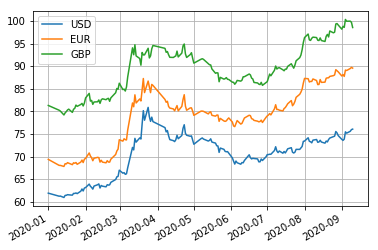

In [11]:
startdate = "1/1/2020"
enddate = datetime.datetime.now()

usd = Currency("usd")
gbp = Currency("GBP")
eur = Currency("eur")

usd_2020 = pd.Series(usd.rate_at_date_range(startdate, datetime.datetime.now()), name=usd.code)
eur_2020 = pd.Series(eur.rate_at_date_range(startdate, datetime.datetime.now()), name=eur.code)
gbp_2020 = pd.Series(gbp.rate_at_date_range(startdate, datetime.datetime.now()), name=gbp.code)

df = pd.concat([usd_2020, eur_2020, gbp_2020], axis=1)
df.plot(legend=True, grid=True)
df.tail(10)